# Bayesian Neural Network Classification Using Pyro on top of Pytorch

In [11]:
# Library import 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

%matplotlib inline

### Simple Neural Network defined by Pytorch

In [12]:
# to define a simple neural network 
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        #fully connected hidden layer
        self.H_out = nn.Linear(input_size, hidden_size)
        #output layer
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.H_out(x)
        output = F.relu(output)
        output = self.out(output)
        return output

### Helper Function

In [27]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [30]:
Batch_Size=128
img_size=28
input_size=1024
output_size=10
learning_rate=0.01
# Number of samples used in prediction stage. 
num_samples = 100
# Threshold for uncertainty 
thre=0.2

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
net = NN(img_size*img_size, input_size, output_size)

### Define the BNN Model Using Pyro

In [14]:
def bnn_model(x_data,label):
    #hidden_layer_weight_prior
    Hw_prior=Normal(loc=torch.zeros_like(net.H_out.weight), scale=torch.ones_like(net.H_out.weight))
    #hidden_layer_bias_prior
    Hb_prior=Normal(loc=torch.zeros_like(net.H_out.bias), scale=torch.ones_like(net.H_out.bias))
    #out_layer_weight_prior
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    #out_layer_weight_bias
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    priors = {'H.weight': Hw_prior, 'H.bias': Hb_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # Pyro will convert the neural netwrok model 
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    #model output
    log_softmax = nn.LogSoftmax(dim=1)
    lhat = log_softmax(lifted_reg_model(x_data))
    pyro.sample("obs", Categorical(logits=lhat), obs=label)

In [15]:
softplus = torch.nn.Softplus()
def model_fit(x_data,label):
    # First layer weight distribution priors
    Hw_mu = torch.randn_like(net.H_out.weight)
    Hw_sigma = torch.randn_like(net.H_out.weight)
    Hw_mu_param = pyro.param("Hw_mu", Hw_mu)
    Hw_sigma_param = softplus(pyro.param("Hw_sigma", Hw_sigma))
    Hw_prior = Normal(loc=Hw_mu_param, scale=Hw_sigma_param)
    # First layer bias distribution priors
    Hb_mu = torch.randn_like(net.H_out.bias)
    Hb_sigma = torch.randn_like(net.H_out.bias)
    Hb_mu_param = pyro.param("Hb_mu", Hb_mu)
    Hb_sigma_param = softplus(pyro.param("Hb_sigma", Hb_sigma))
    Hb_prior = Normal(loc=Hb_mu_param, scale=Hb_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'H.weight': Hw_prior, 'H.bias': Hb_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    lifted_module = pyro.random_module("module", net, priors)
    return lifted_module()

### DataLoading

In [6]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),batch_size=Batch_Size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('mnist-data/', train=False, 
                transform=transforms.Compose([transforms.ToTensor(),])),batch_size=Batch_Size, shuffle=True)

Extracting mnist-data/MNIST/raw/train-images-idx3-ubyte.gz to mnist-data/MNIST/raw


Extracting mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist-data/MNIST/raw


Extracting mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist-data/MNIST/raw




Extracting mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist-data/MNIST/raw
Processing...
Done!


### Model training

In [17]:
## Optimizer
optim = Adam({"lr": learning_rate})
##Stochastic Variational Inference in Pyro
svi = SVI(bnn_model, model_fit, optim, loss=Trace_ELBO())

In [18]:
_iter = 10
loss = 0
for j in range(_iter):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,img_size*img_size), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epoch  0  Loss  32.885249397476514
Epoch  1  Loss  5.859914477141698
Epoch  2  Loss  2.6693717271963755
Epoch  3  Loss  1.6861005781332652
Epoch  4  Loss  1.3323162513653437
Epoch  5  Loss  1.2302752775828043
Epoch  6  Loss  1.2049939410527548
Epoch  7  Loss  1.1718086168924968
Epoch  8  Loss  1.1705498390277227
Epoch  9  Loss  1.1558275618314744


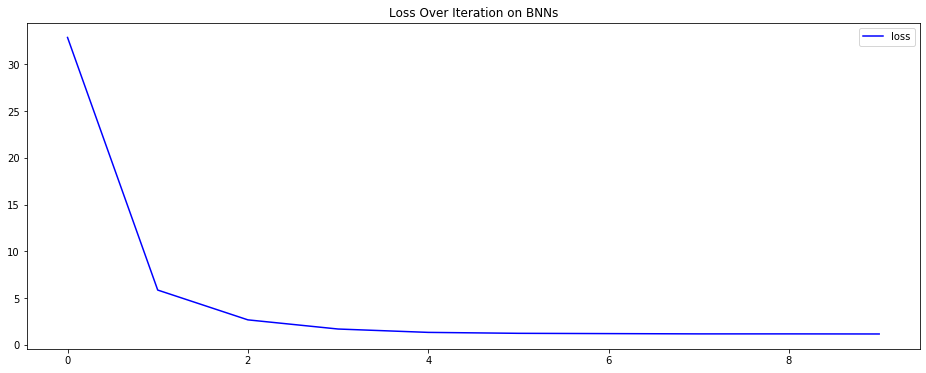

In [78]:
plt.figure(figsize=(16, 6))
plt.plot(range(10), np.array([32.89, 5.86,2.67,1.69,1.33,1.23,1.20,1.17,1.17,1.16]), label='loss',color='blue')
plt.title('Loss Over Iteration on BNNs')
plt.legend();

In [26]:
### Model Prediction and testing 
def predict(x):
    sampled_models = [model_fit(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,img_size*img_size))
    total += labels.size(0)
    correct += (predicted == labels.tolist()).sum().item()
    
print("accuracy: %d %%" % (100 * correct / total))

accuracy: 92 %


### The uncertainties in the Model 

In [65]:
# helper function to get the uncertainties in the model. 
def model_uncertainities(x):
    sampled_models = [model_fit(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,img_size*img_size)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

# Ploting functions to visualize the uncertainties in the model 
def test_data_uncertainties(images, labels, plot=True):
    y = model_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0
    for i in range(len(labels)):
        if(plot):
            print('============================================')
            print("The correct label is: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
        all_digits_prob = []
        highted_something = False
        
        for j in range(len(classes)):
            highlight=False
            histo = []
            histo_exp = []
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            prob = np.percentile(histo_exp, 50) #sampling median probability
            if(prob>thre): 
                highlight = True 
            all_digits_prob.append(prob)
            if(plot):    
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
            if(highlight):
                highted_something = True
                if(plot):
                    fracs = N / N.max()
                    norm = colors.Normalize(fracs.min(), fracs.max())
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)                        
        if(plot):
            plt.show()
        predicted = np.argmax(all_digits_prob)
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("This is a correct prediction")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("This is a wrong prediction")
        else:
            if(plot):
                print('The model is not able to decide what the image is.')
        if(plot):
            imshow(images[i].squeeze())
            print("================================================")
    if(plot):
        print("=======Summary========")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        if predicted_for_images!=0:
            print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
    return len(labels), correct_predictions, predicted_for_images
            

In [49]:
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    total_minibatch, correct_minibatch, predictions_minibatch = test_data_uncertainties(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch
    
print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

128 117.0 122
128 117.0 121
128 117.0 125
128 113.0 121
128 121.0 127
128 120.0 126
128 118.0 123
128 115.0 121
128 112.0 124
128 124.0 125
128 119.0 124
128 122.0 124
128 116.0 122
128 118.0 123
128 121.0 128
128 114.0 122
128 113.0 122
128 120.0 123
128 118.0 124
128 116.0 126
128 118.0 127
128 116.0 122
128 122.0 126
128 114.0 123
128 118.0 124
128 119.0 126
128 117.0 125
128 113.0 120
128 119.0 124
128 110.0 121
128 112.0 119
128 116.0 123
128 120.0 126
128 121.0 123
128 108.0 121
128 123.0 127
128 112.0 121
128 118.0 123
128 123.0 126
128 113.0 123
128 118.0 123
128 118.0 122
128 125.0 127
128 121.0 125
128 122.0 126
128 121.0 124
128 122.0 126
128 125.0 127
128 115.0 123
128 118.0 123
128 120.0 125
128 123.0 126
128 121.0 124
128 120.0 126
128 116.0 123
128 111.0 120
128 116.0 124
128 115.0 119
128 118.0 124
128 116.0 125
128 119.0 124
128 113.0 121
128 117.0 124
128 115.0 122
128 118.0 123
128 117.0 122
128 115.0 126
128 120.0 125
128 121.0 125
128 122.0 126
128 116.0 123
128 11

The correct label is:  1


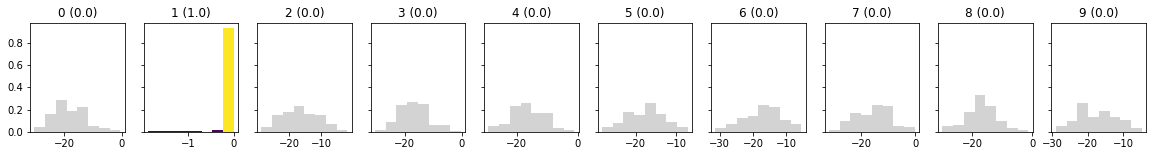

This is a correct prediction


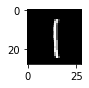

========This is a correct prediction============
The correct label is:  0


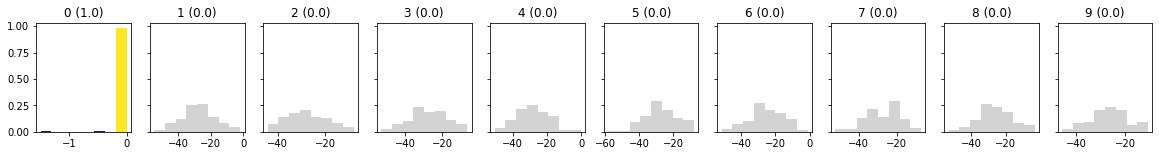

This is a correct prediction


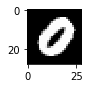

========This is a correct prediction============
The correct label is:  3


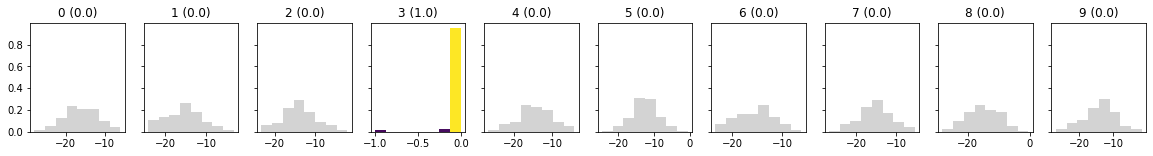

This is a correct prediction


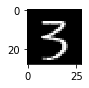

========This is a correct prediction============
The correct label is:  6


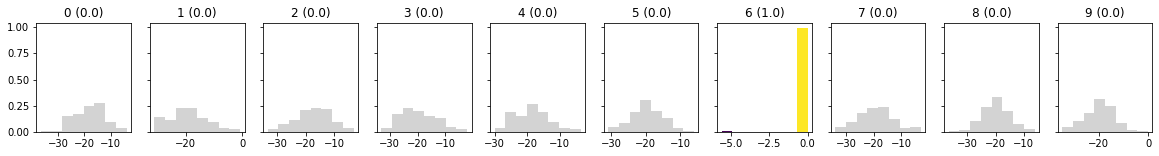

This is a correct prediction


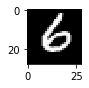

========This is a correct prediction============
The correct label is:  1


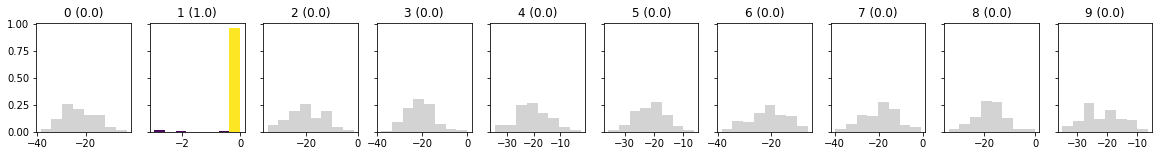

This is a correct prediction


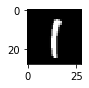

========This is a correct prediction============
The correct label is:  8


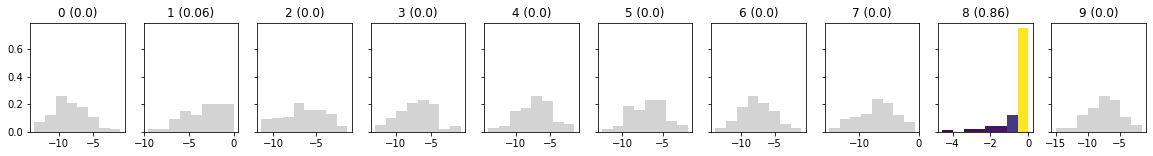

This is a correct prediction


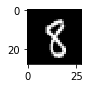

========This is a correct prediction============
The correct label is:  3


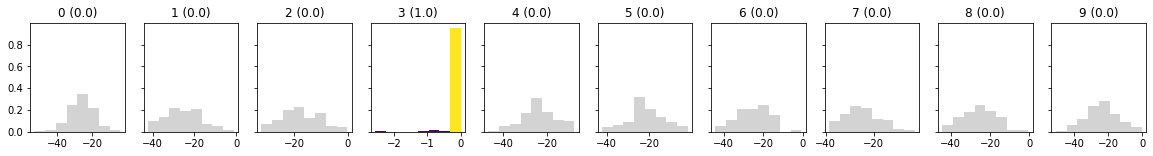

This is a correct prediction


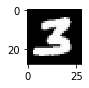

========This is a correct prediction============
The correct label is:  9


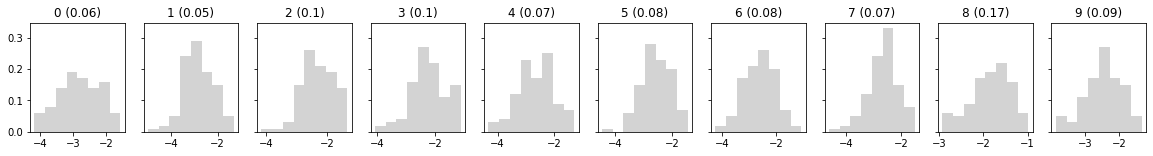

The model is not able to decide what the image is.


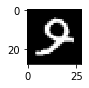

========This is a correct prediction============
The correct label is:  9


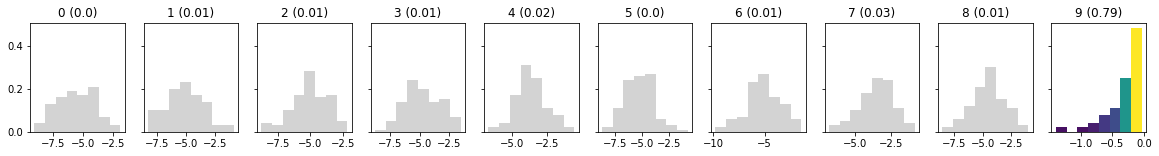

This is a correct prediction


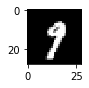

========This is a correct prediction============
The correct label is:  1


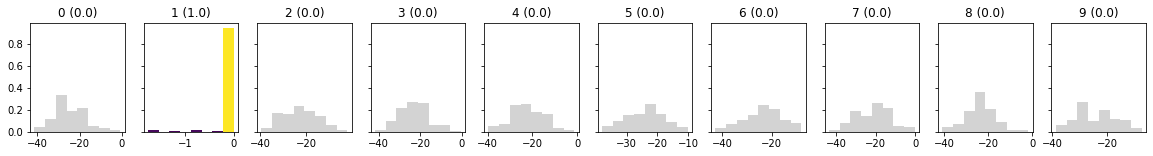

This is a correct prediction


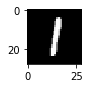

========This is a correct prediction============
=======Summary========
Total images:  10
Predicted for:  9
Accuracy when predicted:  1.0


(10, 9.0, 9)

In [48]:
test_data_uncertainties(images[:10], labels[:10])

### Fool the model using random noise 

In [62]:
images_random = torch.rand(1000,28,28)
labels_random = torch.randint(0,10, (1000,))
test_data_uncertainties(images_random, labels_random,plot=False)

(1000, 0, 2)

/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


The correct label is:  3


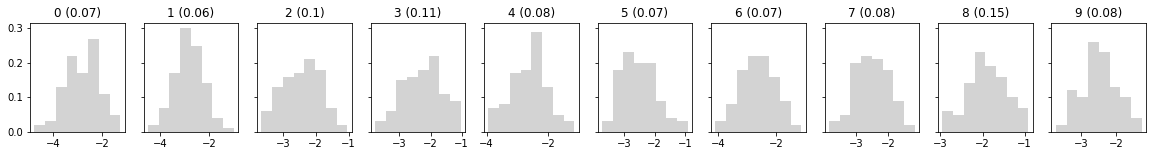

The model is not able to decide what the image is.


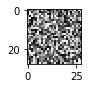

The correct label is:  2


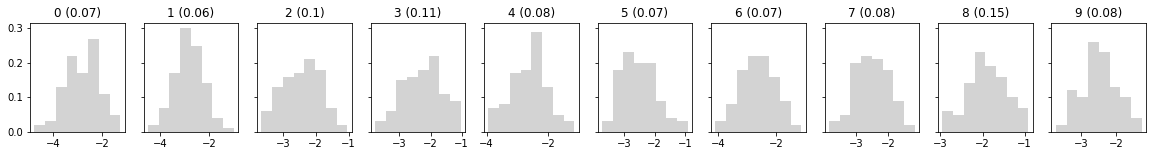

The model is not able to decide what the image is.


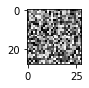

The correct label is:  6


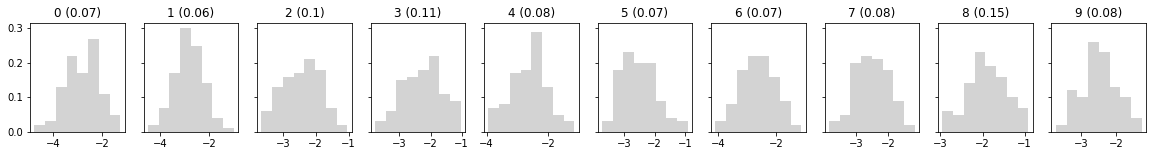

The model is not able to decide what the image is.


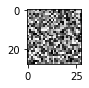

The correct label is:  1


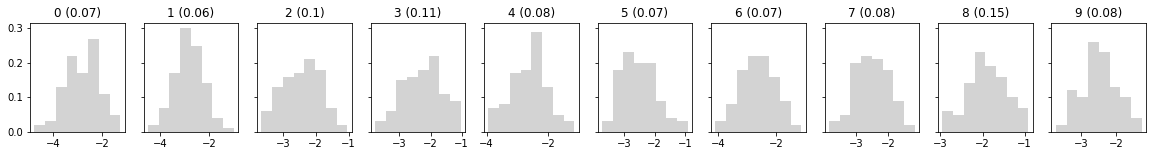

The model is not able to decide what the image is.


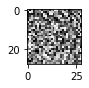

The correct label is:  1


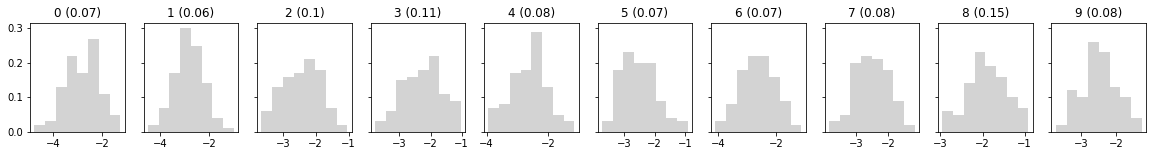

The model is not able to decide what the image is.


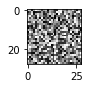

The correct label is:  1


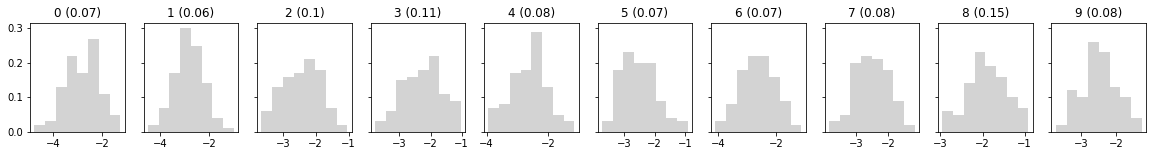

The model is not able to decide what the image is.


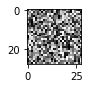

The correct label is:  2


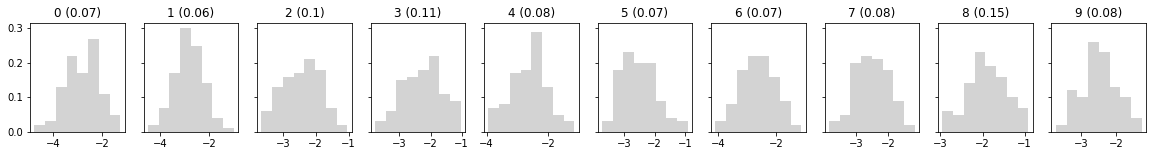

The model is not able to decide what the image is.


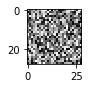

The correct label is:  9


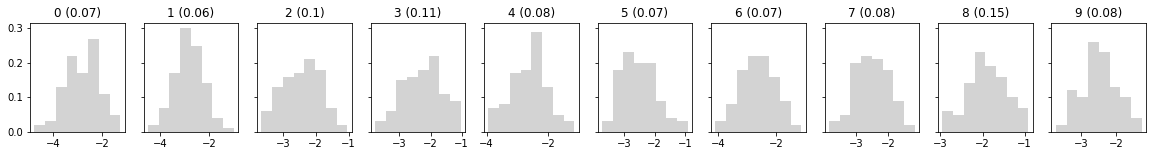

The model is not able to decide what the image is.


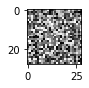

The correct label is:  9


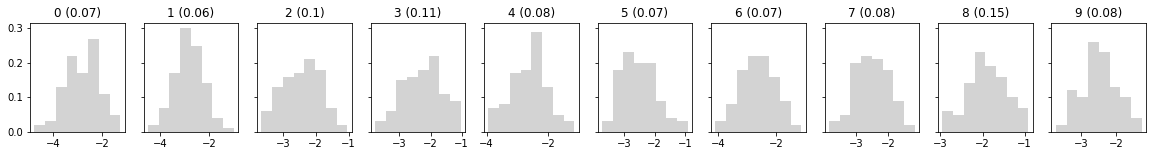

The model is not able to decide what the image is.


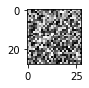

The correct label is:  3


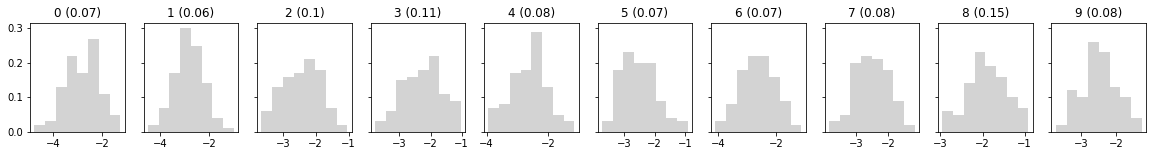

The model is not able to decide what the image is.


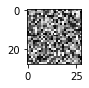

=======Summary========
Total images:  10
Predicted for:  0


(10, 0, 0)

In [66]:
test_data_uncertainties(images_random[0:10], labels_random[0:10],plot=True)

### Fool the model using alphabet data

In [71]:
class alphabet_data_loader(Dataset):
    def __init__(self, root):
        Images, Y = [], []
        folders = os.listdir(root)
        folders = folders[1:]
        for folder in folders:
            folder_path = os.path.join(root, folder)
            print(folder_path)    
            for ims in os.listdir(folder_path):
                if '.png' in ims:
                    img_path = os.path.join(folder_path, ims)
                    Images.append(np.array(imread(img_path)))
                    Y.append(ord(folder) - 65)
        data = [(x, y) for x, y in zip(Images, Y)]
        self.data = data
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]
        img = img.reshape(1, 28, 28) / 255
        img_tensor = transforms.ToTensor()(img).view(1, 28, 28).float()
        label = self.data[index][1]
        return (img_tensor, label)

In [72]:
test_dataset_notmnist = alphabet_data_loader('not-mnist')
test_loader_notmnist = DataLoader(test_dataset_notmnist, batch_size=128, shuffle=True)

not-mnist/I
not-mnist/G
not-mnist/A
not-mnist/F
not-mnist/H
not-mnist/J


/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':


not-mnist/C
not-mnist/D
not-mnist/E
not-mnist/B


In [73]:
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader_notmnist):
    images, labels = data
    total_minibatch, correct_minibatch, predictions_minibatch = test_data_uncertainties(images, labels, plot=False)
    total += total_minibatch
    total_predicted_for += predictions_minibatch
print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)

/Users/Shaoyu/anaconda3/lib/python3.6/site-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Total images:  455
Skipped:  243


The correct label is:  5


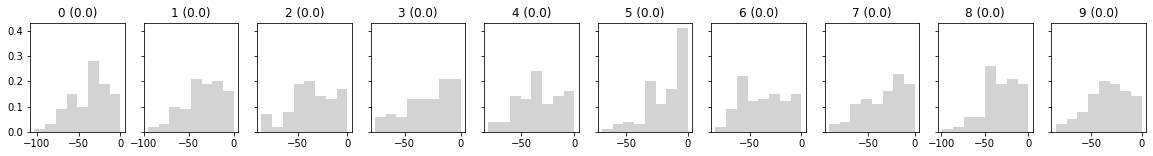

The model is not able to decide what the image is.


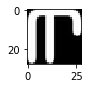

The correct label is:  6


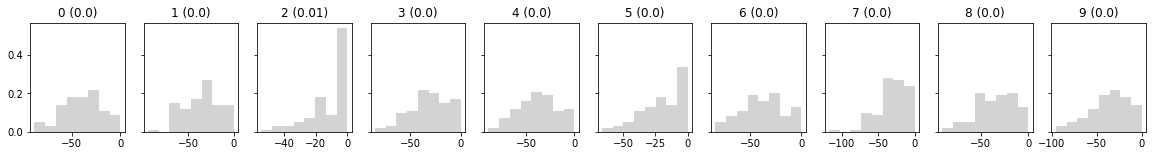

The model is not able to decide what the image is.


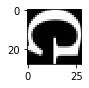

The correct label is:  1


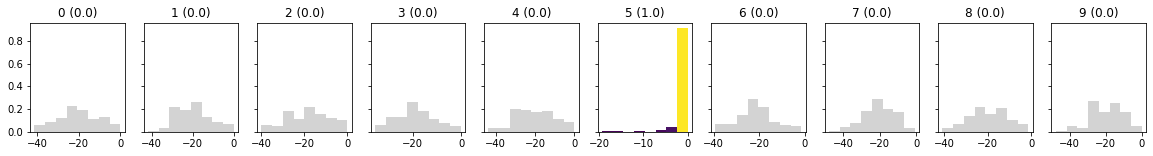

This is a wrong prediction


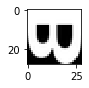

The correct label is:  1


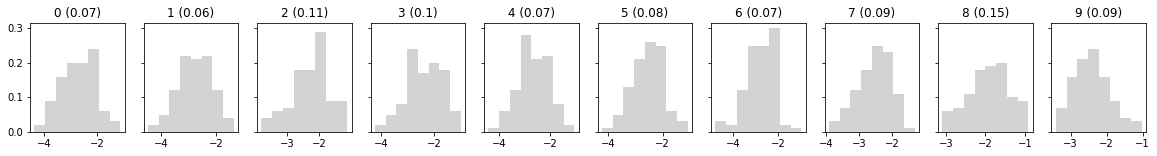

The model is not able to decide what the image is.


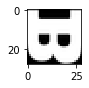

The correct label is:  4


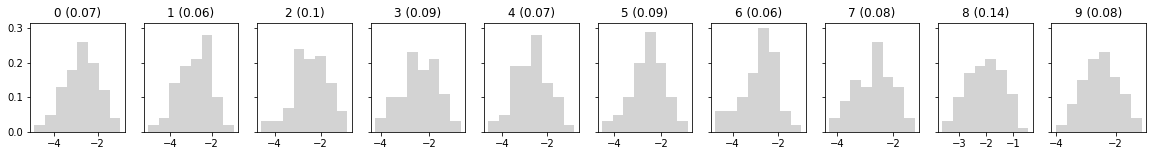

The model is not able to decide what the image is.


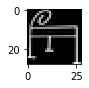

The correct label is:  6


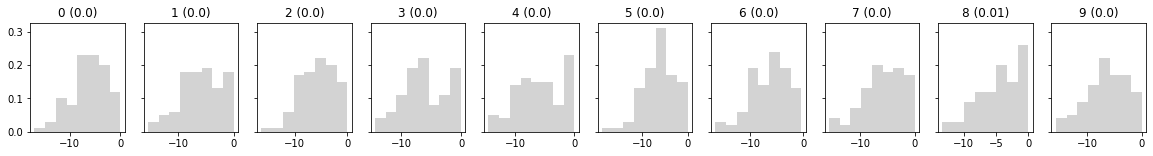

The model is not able to decide what the image is.


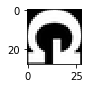

The correct label is:  2


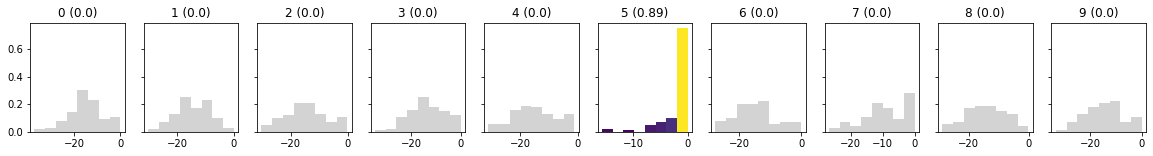

This is a wrong prediction


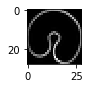

The correct label is:  0


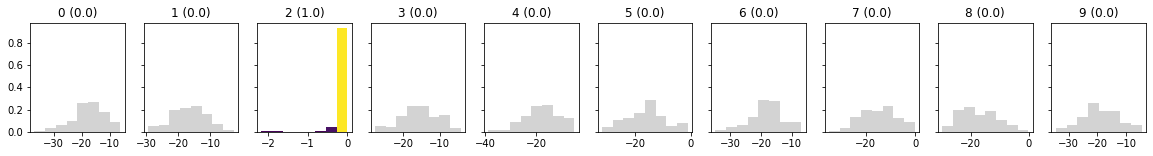

This is a wrong prediction


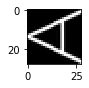

The correct label is:  7


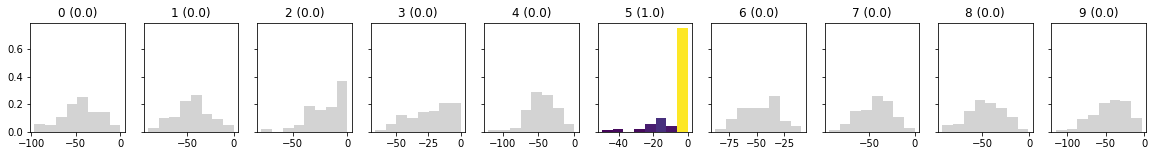

This is a wrong prediction


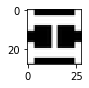

The correct label is:  2


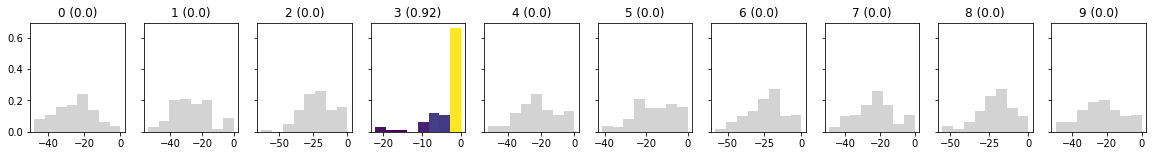

This is a wrong prediction


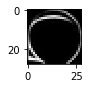

The correct label is:  8


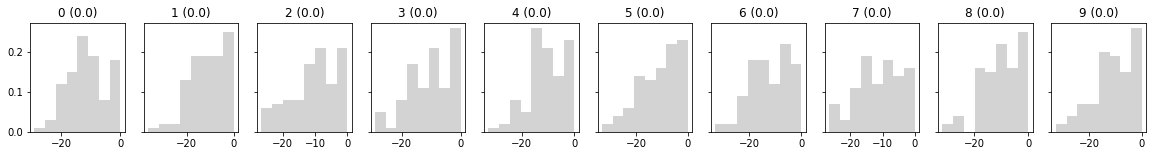

The model is not able to decide what the image is.


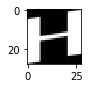

The correct label is:  2


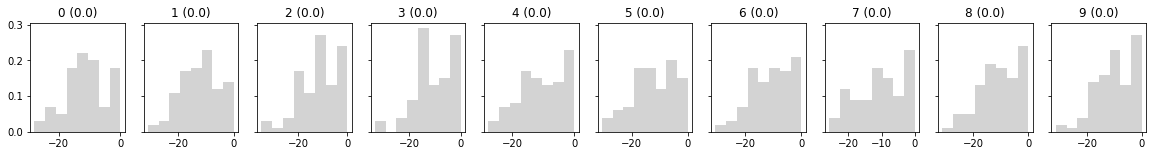

The model is not able to decide what the image is.


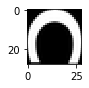

The correct label is:  5


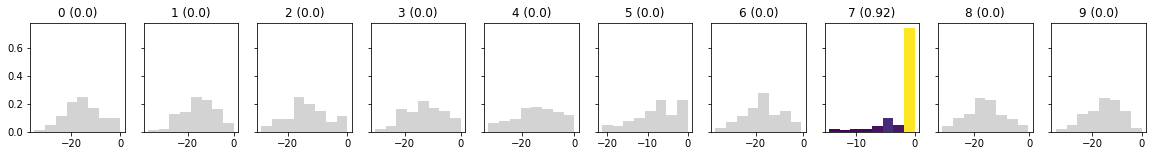

This is a wrong prediction


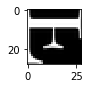

The correct label is:  9


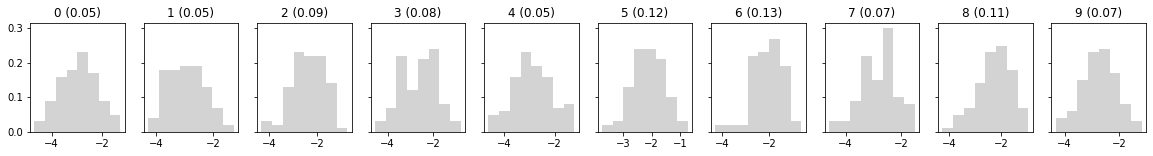

The model is not able to decide what the image is.


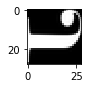

The correct label is:  2


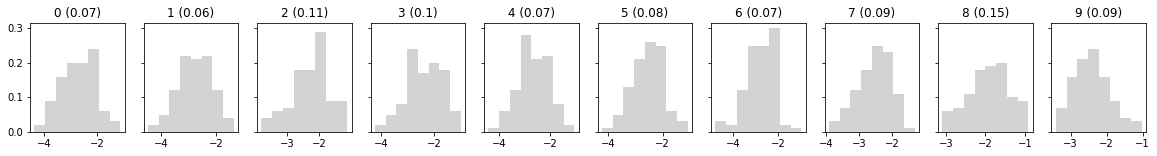

The model is not able to decide what the image is.


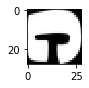

=======Summary========
Total images:  15
Predicted for:  6
Accuracy when predicted:  0.0


(15, 0, 6)

In [75]:
test_data_uncertainties(images[0:15], labels[0:15], plot=True)